# Clasificación de audio con el Perceptrón Multicapa II

## Dataset
Este conjunto de datos contiene los discursos de estos líderes prominentes; Benjamín Netanyahu, Jens Stoltenberg, Julia Gillard, Margaret
Tacher y Nelson Mandela que también representa los nombres de las carpetas. Cada audio de la carpeta es un PCM de un segundo de duración con una velocidad de muestreo de 16000 hz codificado.
Una carpeta llamada background_noise contiene audios que no son discursos, pero que se pueden encontrar en el interior alrededor del entorno del orador, por ejemplo, la audiencia riendo o aplaudiendo. Se puede mezclar con el discurso mientras se entrena.

### Referencias
https://www.kaggle.com/kongaevans/speaker-recognition-dataset/

## Enunciado

El objetivo del ejercicio consiste en utilizar un perceptrón multicapa para la identificación de la persona que se encuentra hablando a partir de un audio de un segundo de duración.

## Parte I: Introducción al procesamiento de audio

En primera instancia debemos comprender como se representa digitalmente el audio y que características fundamentales tiene.

In [2]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = "16000_pcm_speeches"
BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")
JENS_DATA = os.path.join(DATASET_ROOT, "Jens_Stoltenberg")
JULIA_DATA = os.path.join(DATASET_ROOT, "Julia_Gillard")
MARGARET_DATA = os.path.join(DATASET_ROOT, "Magaret_Tarcher")
NELSON_DATA = os.path.join(DATASET_ROOT, "Nelson_Mandela")

Para procesar el audio vamos a requerir una librería externa que debemos instalar en el contexto de nuestro Jupyter Notebook, concretamente la librería que vamos a utilizar es librosa: https://librosa.org/doc/latest/index.html

In [3]:
# Escuchamos el fichero de audio que vamos a cargar en el contexto de Jupyter Notebook
import IPython.display as ipd

ipd.Audio(os.path.join(BENJAMIN_DATA, "22.wav"))

In [4]:
# Cargamos el audio mediante la librería librosa
import librosa

wav, sr = librosa.load(os.path.join(BENJAMIN_DATA, "22.wav"))

El método load de librosa nos devuleve dos resultados:
1. Nos devuelve la onda que representa el sonido que estamos cargando en el contexto de nuestro Jupyter Notebook
2. Nos devuelve el ratio de sampleo 

El sonido es una señal analógica, para poder hacerla digital y poderla representar numéricamente tenemos que muestrear la señal original. 

El muestreo consiste en "seleccionar" un número finito de puntos de la señal original y almacenarlos en una matriz. El teorema de muestreo de Nyquist-Shannon mostró que si nuestra tasa de muestreo es lo suficientemente alta, somos capaces de capturar toda la información de la señal e incluso recuperarla completamente.

In [5]:
print(wav)

[ 0.0378246   0.07599634  0.14084503 ... -0.01175935  0.01080641
  0.01450372]


In [6]:
print(sr)

22050


La tasa de muestreo es muy importante, y la usaremos más adelante en diferentes algoritmos. Generalmente se expresa en hercios (Hz), es decir, el número de puntos (muestras) por segundo. 

En nuestro ejemplo, sr=22050 por lo que tenemos 22050 muestras por segundo, por lo tanto, podemos calcular la longitud del audio de la siguiente forma:

In [7]:
# Con la tasa de muestreo y el tamaño total de la señal se puede calcular la longitud del audio
long_audio = len(wav)/sr
print("La longitud del audio en segundos es:", long_audio)

La longitud del audio en segundos es: 1.0


Una de las cosas interesantes que debemos hacer para obtener intuiciones sobre nuestra onda de sonido es representarla gráficamente

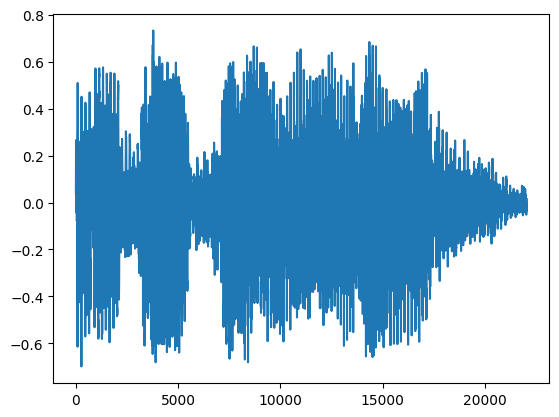

In [8]:
# Representación gráfica de la onda de sonido
from matplotlib import pyplot as plt

plt.plot(wav)
plt.show()

También podemos hacer zoom en determinados puntos específicos seleccionados durante el muestreo

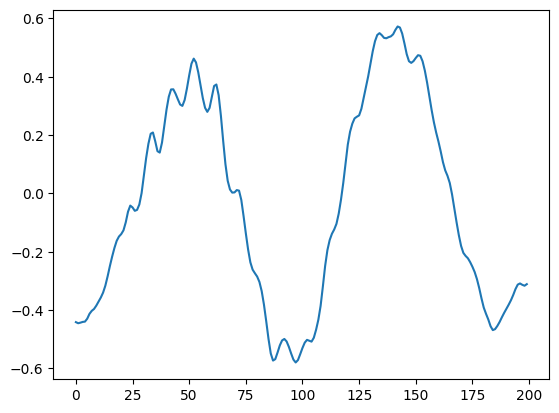

In [9]:
plt.plot(wav[1000:1200])
plt.show()

Hay algo importante que debemos tener en cuenta respecto a lo comentado anteriormente, en realidad, la tasa de muestreo real para el audio que hemos cargado no es 22050 Hz, librosa implícitamente remuestrea nuestros archivos para obtener este valor estándar. Para obtener la tasa de muestreo original, podemos usar el argumento **_sr=False_** en el método **_load_**:

In [11]:
wav, sr = librosa.load(os.path.join(BENJAMIN_DATA, "22.wav"), sr=None)

In [10]:
print("Tasa de muestreo: {} Hz".format(sr))

Tasa de muestreo: 22050 Hz


## 1. Preparación del conjunto de datos

Vamos a comenzar intentando utilizar esta representación del sonido para tratar de identificar el orador al que pertenece la grabación mediante el uso de un Perceptrón Multicapa.

Hay que tener en cuenta que para este tipo de casos prácticos debemos intentar buscar las voces de los oradores emitidas por diferentes altavoces o dispositivos de sonido para que la clasificación no dependa del altavoz que se esta utilizando.

In [12]:
# Definimos una función para parsear nuestro conjunto de datos
def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            X.append(wav)
            y.append(index)
    return (X, y)

In [13]:
X, y = parse_dataset([BENJAMIN_DATA, JENS_DATA])

[+] Parsing 16000_pcm_speeches\Benjamin_Netanyau data...
[+] Parsing 16000_pcm_speeches\Jens_Stoltenberg data...


In [14]:
print("La longitud del conjunto de datos es: ", len(X))

La longitud del conjunto de datos es:  3000


## 2. División del conjunto de datos

In [15]:
# Dividimos el conjunto de datos en entrenamiento y pruebas
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [16]:
print("Longitud del subconjunto de entrenamiento: ", len(X_train))
print("Longitud del subconjunto de pruebas: ", len(X_test))

Longitud del subconjunto de entrenamiento:  2850
Longitud del subconjunto de pruebas:  150


## 3. Construcción del modelo

In [17]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train, y_train)

C:\Users\Hugo\anaconda3\envs\curso_deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [18]:
# Realizamos la predicción con el conjunto de datos de prueba
y_pred = clf.predict(X_test)

In [19]:
# Mostramos el f1_score resultante de la clasificación
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average="binary")

0.5599999999999999

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[24, 51],
       [26, 49]], dtype=int64)

# Parte II: Otra representación del sonido

Como podemos observar en el ejercicio anterior, si utilizamos las ondas tal cual las estamos leyendo de disco, los resultados de nuestro algoritmo no son demasiado buenos. Por ello, vamos a utilizar otra representación del sonido conocida como espectrogramas.

Antes de comprender lo que es un espectrograma, debemos comprender lo que son las ondas coseno o cosinusoide

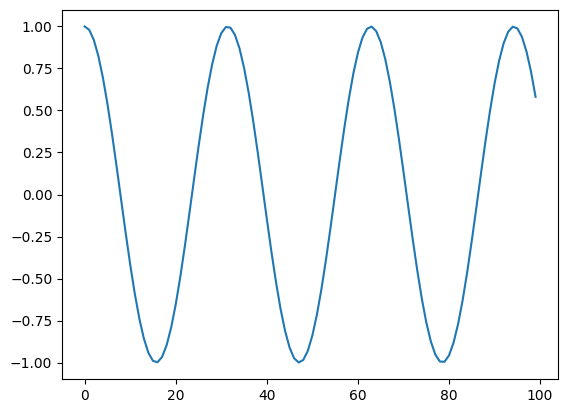

In [21]:
import numpy as np

signal = np.cos(np.arange(0, 20, 0.2))

plt.plot(signal)
plt.show()

Puede observarse que se corresponden con un tipo de ondas sencillas, cuya curva describe una oscilación repetitiva y suave. De manera muy sencilla podemos modificar este patrón cambiando la amplitud y frequencia de la onda.

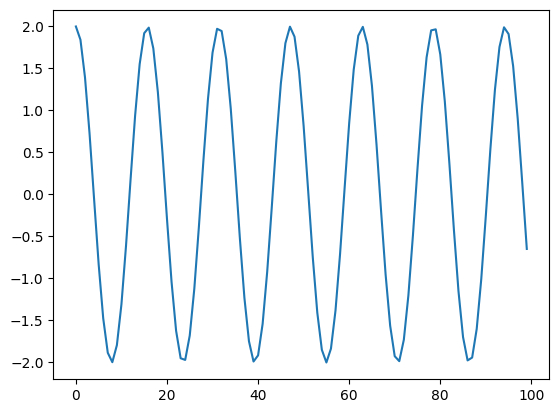

In [22]:
signal = 2*np.cos(np.arange(0, 20, 0.2)*2)

plt.plot(signal)
plt.show()

También podemos combinar dos ondas de este tipo formando ondas más complejas:

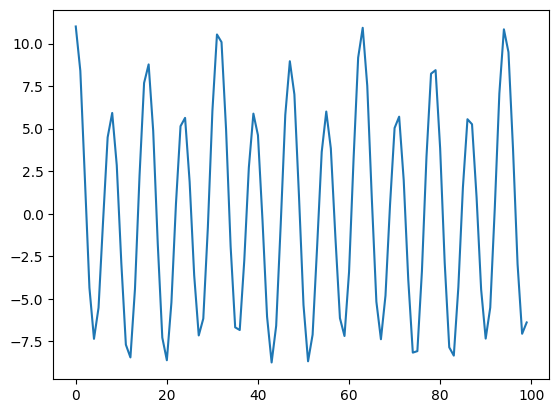

In [23]:
cos1 = np.cos(np.arange(0, 20, 0.2))
cos2 = 2*np.cos(np.arange(0, 20, 0.2)*2)
cos3 = 8*np.cos(np.arange(0, 20, 0.2)*4)

signal = cos1 + cos2 + cos3

plt.plot(signal)
plt.show()

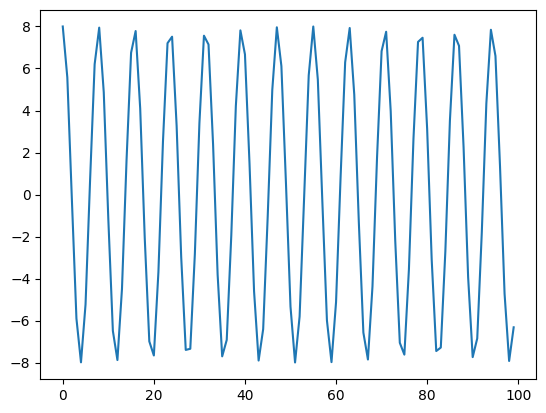

In [24]:
import numpy as np
import matplotlib.pyplot as plt
cos3 = 8*np.cos(np.arange(0, 20, 0.2)*4)

plt.plot(cos3)
plt.show()

Para poder proporcionar estas ondas a nuestra Red Neuronal Artificial necesitamos una representación de la misma. Podemos utilizar varias representaciones. 
1. Almacenar la señal completa, que es considerablemente compleja y que hemos comprobado que no proporciona demasiado buenos resultados
2. Podemos almacenar únicamente las frequencias que se utilizan en esta señal.

Representar únicamente las frecuencias de la señal es más simple y requiere mucho menos espacio en memoria. Aquí tenemos 3 frecuencias diferentes con diferentes amplitudes. La pregunta que debemos hacer es: ¿Cuáles son exactamente esas 3 frecuencias?

Necesitamos un método que, dada una onda digital, nos devuelva las frecuencias en ella. Para ello vamos a utilizar la Transformada de Fourier.

Utilizamos numpy para implementar esta función.

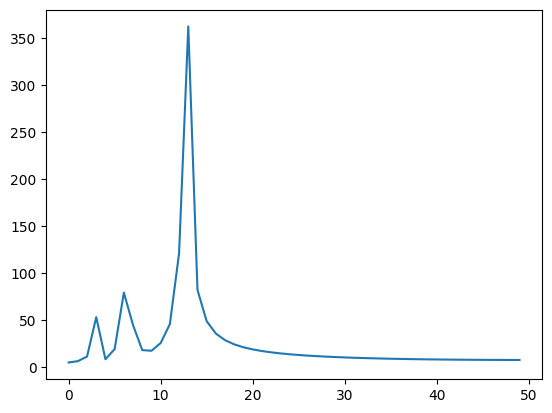

In [26]:
fft = np.fft.fft(signal)[:50]
fft = np.abs(fft)

plt.plot(fft)
plt.show()

Vemos aquí 3 frecuencias: 4, 7 y 14 bits por segundo, exactamente como construimos nuestra señal. Aquí usamos sólo la primera mitad del valor de retorno porque el resultado de la FFT es simétrico.

Resulta que cada sonido (incluso el habla humana) está compuesto de muchas de estas ondas coseno básicas en diferentes frecuencias.

Tenemos una forma de obtener frecuencias de cualquier señal de sonido, pero el habla humana no es un ruido estático, cambia con el tiempo, así que para representar correctamente el habla humana, descompondremos nuestras grabaciones en pequeñas ventanas y calcularemos qué frecuencias se utilizan en cada ventana.

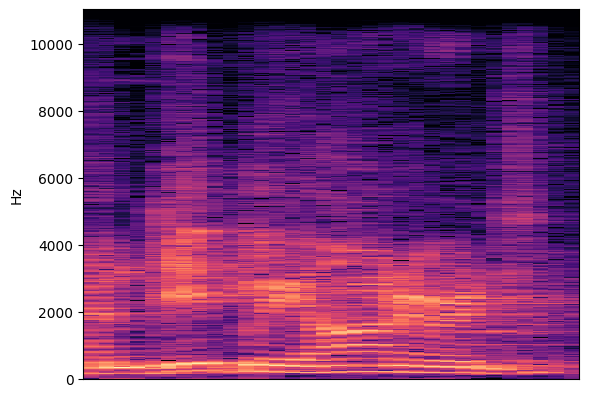

In [27]:
import librosa.display

D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)

librosa.display.specshow(D, y_axis='linear')
plt.show()

* **_librosa.stft_**: calcula la Transformada de Fourier. Los valores de retorno son una matriz donde X son los números de ventana e Y son las frecuencias. 
* **_np.abs_**: Toma el absoluto del stft en caso de número complejo devuelve el absoluto de la parte real.
* **_librosa.amplitud_a_db_**: Convierte los valores a Decibelios
* **_librosa.display.specshow_**: Muestra el espectrograma.


El espectrograma nos muestra diferentes frecuencias en diferentes partes de la grabación de la voz. Otra de las propiedades fundamentales es que a nivel de representación son muy similares a una imagen en blanco y negro

In [28]:
# El espectrograma puede interpretarse como una imagen
D.shape

(1025, 32)

## 1. Preparación del conjunto de datos

In [29]:
# Definimos una función para parsear nuestro conjunto de datos
import librosa

def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print("[+] Parsing {} data...".format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
            X.append(D)
            y.append(index)
    return (X, y)

In [30]:
# X_prep, y_prep = parse_dataset([BENJAMIN_DATA, JENS_DATA])
X_prep, y_prep = parse_dataset([JENS_DATA, JULIA_DATA, MARGARET_DATA, NELSON_DATA])

[+] Parsing 16000_pcm_speeches\Jens_Stoltenberg data...
[+] Parsing 16000_pcm_speeches\Julia_Gillard data...
[+] Parsing 16000_pcm_speeches\Magaret_Tarcher data...
[+] Parsing 16000_pcm_speeches\Nelson_Mandela data...


In [31]:
X_prep[100].max()

-3.8146973e-06

## 2. División del conjunto de datos

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y_prep, test_size=0.05)

In [33]:
print(len(X_train))
print(len(X_test))

5700
301


## 3. Construcción del modelo

Preprocesamos los subconjuntos de datos para que puedan ser posteriormente procesados por la red neuronal artificial

In [34]:
X_train_prep = np.array(X_train).reshape((len(X_train), 1025*32))
X_train_prep = np.array(X_train_prep).astype('float32') / 255
y_train_prep = np.array(y_train)

X_test_prep = np.array(X_test).reshape((len(X_test), 1025*32))
X_test_prep = np.array(X_test_prep).astype('float32') / 255
y_test_prep = np.array(y_test)

In [35]:
X_train_prep[0]

array([-0.20322911, -0.18993439, -0.19904965, ..., -0.3137255 ,
       -0.2668064 , -0.22800258], dtype=float32)

In [36]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train_prep, y_train_prep)

C:\Users\Hugo\anaconda3\envs\curso_deep_learning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [37]:
# Realizamos la predicción con el conjunto de datos de prueba
y_pred = clf.predict(X_test_prep)

In [38]:
# Mostramos el f1_score resultante de la clasificación
from sklearn.metrics import f1_score

# f1_score(y_test, y_pred, average="binary")
f1_score(y_test, y_pred, average="weighted")

0.933805262914179